# Biomolecules Identification by Raman spectroscopy
This notebook shows an example of how to use the library to identify an unkown biomolecule from a Raman spectrum. 

In [1]:
# Install ramanbiolib
#!pip install ramanbiolib

In [ ]:
# In Windows is often necessary to set the default renderer of plotly to see the plots (Uncomment this if necessary)
#import plotly.io as pio
#pio.renderers.default = 'iframe'

In [3]:
import sys
import pandas as pd
import numpy as np
import plotly.express as px
from scipy.signal import find_peaks

In [4]:
from ramanbiolib.search import PeakMatchingSearch, SpectraSimilaritySearch

## Load data
A collagen Raman specturm is used in this example. The spectrum is saved in a CSV file containing two columns: wavenumbers and intensity.

In [5]:
collagen_example_df = pd.read_csv("collagen_example.csv")

In [6]:
wavenumbers = collagen_example_df['wavenumbers'].to_numpy()
unknown_spectrum  = collagen_example_df['intensity'].to_numpy()

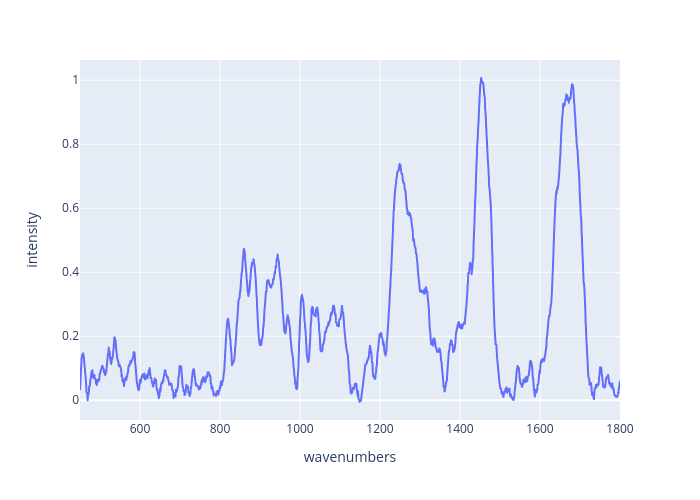

In [7]:
px.line(collagen_example_df, x='wavenumbers', y='intensity')

## Identification search
The identification search is performed over the loaded spectrum using both spectra similarity and peak matching search.

### Spectra similarity
Spectra similarity search uses the full spectra trace to rank the database components by its similarity to the unknown specturm.  

First we need to create the search object initializing the wavenumbers list that defines the spectrum trace x values. Maximum database range is 450-1800 cm⁻¹.  
By default the database spectra are saved using the maximum range with a 1 cm⁻¹ step.  
Database spectra are interpolated linearly to fit the wavenumbers list if a custom value is added.

In [8]:
spectra_search = SpectraSimilaritySearch(wavenumbers=wavenumbers)

We can search using the search function passing the unkown spectrum.

Parameters:
- **unknown_spectrum**: Unknown spectrum intensity trace. The values must be interpolated to match the wavenumbers list specified when creating the SpectraSimilaritySearch object.
- **class_filter**: List of classes to consider in the results. Default value is None, all cases considered.
- **unique_components_in_results**: True when only the best result for each component, in the database, is shown in the results. False to have all measures in the results.
- **similarity_method**: Similarity score used for results ranking. Values: euclidean, cosine_similarity, slk. Default: slk.
- **similarity_params**: In SLK case, the value of the window (W) parameter. Is ignored in other cases.


In [9]:
search_results = spectra_search.search(
    unknown_spectrum,
    class_filter=None,
    unique_components_in_results=True,
    similarity_method="slk",
    similarity_params=25 # Window size
)

Use get_results to show the top N results

In [10]:
search_results.get_results(limit=10)

,type,id,component,laser,reference,source,similarity_score
0,Proteins,105,collagen,488.0,https://doi.org/10.1002/jrs.4335,digitized,0.998757
1,Proteins,131,pepsin,488.0,https://doi.org/10.1002/jrs.4335,digitized,0.792926
2,Proteins,141,superoxide dismutases,532.0,https://doi.org/10.1002/jrs.4335,digitized,0.771907
3,Proteins,191,elastin,1064.0,https://doi.org/10.1074/jbc.270.44.26099,digitized,0.770450
4,Proteins,146,trypsin inhibitor,488.0,https://doi.org/10.1002/jrs.4335,digitized,0.754353
5,Proteins,158,ubiquitin,488.0,https://doi.org/10.1002/jrs.4335,digitized,0.733471
6,Proteins,139,major proteinase,1064.0,https://doi.org/10.1002/jrs.4335,digitized,0.723487
7,Proteins,144,trypsinogen,532.0,https://doi.org/10.1002/jrs.4335,digitized,0.720730
8,Proteins,156,trypsin,532.0,https://doi.org/10.1002/jrs.4335,digitized,0.716173
9,Proteins,151,thaumatin,1064.0,https://doi.org/10.1002/jrs.4335,digitized,0.688435


Use plot_results to compare search query spectrum with top N results

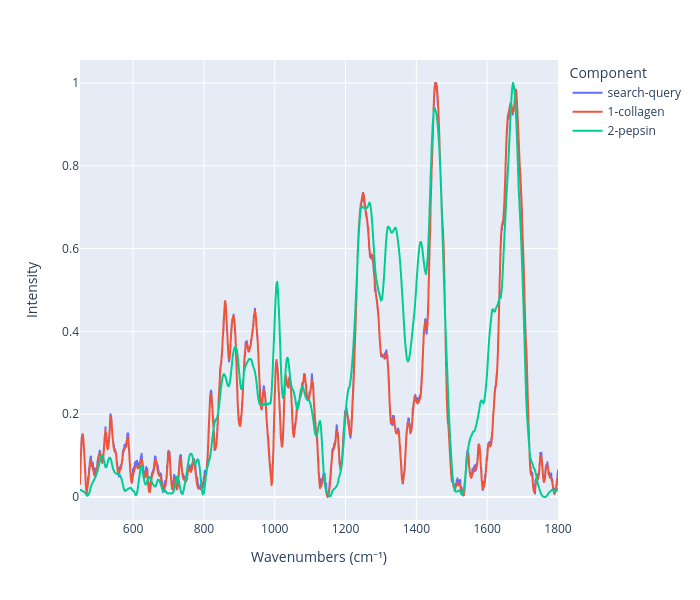

In [11]:
search_results.plot_results(n=2)

Use plot_score to display the score decrement over the ranked results

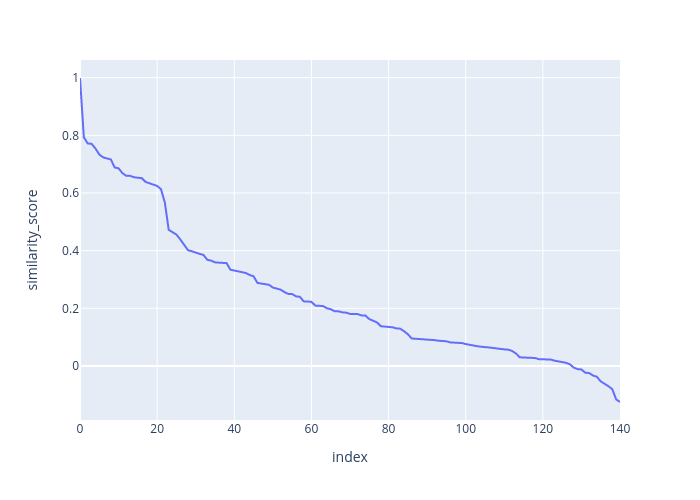

In [12]:
search_results.plot_scores()

### Peak matching
Peak matching calculate the matching between the specturm extracted peaks positions and each database components peaks positions,   calculating the matching ratio (MR), reverse matching ratio (RMR), ntersection over the union ratio (IUR), and the penalized intersection over the union ratio (PIUR).

First we need to create the search object initializing the wavenumbers (integer) list that defines the considered wavenumbers range. Maximum database range is 450-1800 cm⁻¹ 

In [13]:
pm_search = PeakMatchingSearch(wavenumbers=wavenumbers)

Then we need to extract the most relevants peaks positions (in wavenumbers) of the unknown spectrum. Any tool can be used, in this example scipy find_peaks functions setting a minimum prominence of 0.1.

In [14]:
peaks, _ = find_peaks(unknown_spectrum, prominence=0.1)
peaks_wavenumbers = wavenumbers[peaks]
peaks_wavenumbers

array([ 458.,  536.,  586.,  820.,  860.,  884.,  944., 1005., 1031.,
       1083., 1175., 1249., 1453., 1576., 1680.])

Finally, we can search using the search function passing the extracted peaks positions.  
  
Parameters:
- **peaks_wavenumbers**: list of unknown spectrum peaks positions in wavenumbers (integer).
- **tolerance**: Simmetrical maximum distance tolerance for peak matching. Default 0, only exact match.
- **class_filter**: List of classes to consider in the results. Default value is None, all cases considered.
- **sort_score**: Matching score metric to use for the results ranking. Values: MR, RMR, IUR, PIUR. Default IUR.
  - Considering query spectrum peaks Pa and DB spectrum peaks Pb: 
    - MR (Matching Ratio) = intersection(Pa, Pb)/len(Pa) 
    - RMR (Reverse Matching Ratio) = intersection(Pa, Pb)/len(Pb) 
    - IUR (Intersection Union Ratio) = intersection(Pa, Pb)/union(Pa, Pb) 
    - PIUR (Penalized Intersection Union Ratio) = penalized_intersection(Pa, Pb)/union(Pa, Pb) 
- **min_peak_intensity**: Minimum intensity value for database peaks considering the the matching (between 0-1). Default value 0.
- **tol_penalty**: Type of penalty function applied for PIUR calculation. Values: linear or inverse_power. Default linear.
- **unique_components_in_results**: True when only the best result for each component, in the database, is shown in the results. False to have all measures in the results.

In [15]:
pm_search_results = pm_search.search(
        peaks_wavenumbers,
        tolerance=5,
        class_filter=None,
        sort_score='IUR',
        min_peak_intensity=0,
        tol_penalty="linear",
        unique_components_in_results=True
    )

Use get_results to show the top N results

In [16]:
pm_search_results.get_results(limit=10, sort_col='IUR')

,type,id,component,laser,reference,source,MR,RMR,IUR,PIUR
0,Proteins,106.0,collagen,532.0,https://doi.org/10.1002/jrs.4335,digitized,0.533333,0.615385,0.555556,0.370370
1,Proteins,141.0,superoxide dismutases,532.0,https://doi.org/10.1002/jrs.4335,digitized,0.533333,0.500000,0.516129,0.322581
2,Proteins,134.0,pepsinogen,488.0,https://doi.org/10.1002/jrs.4335,digitized,0.466667,0.466667,0.466667,0.211111
3,Proteins,123.0,lectin,488.0,https://doi.org/10.1002/jrs.4335,digitized,0.466667,0.388889,0.406250,0.166667
4,Saccharides/Monosaccharides,187.0,d-(-)-ribose,1064.0,https://doi.org/10.1016/j.saa.2017.05.045,digitized,0.466667,0.333333,0.388889,0.268519
5,Proteins,131.0,pepsin,488.0,https://doi.org/10.1002/jrs.4335,digitized,0.400000,0.375000,0.387097,0.215054
6,Proteins,157.0,trypsin,1064.0,https://doi.org/10.1002/jrs.4335,digitized,0.400000,0.400000,0.379310,0.275862
7,Proteins,104.0,carbonic anhydrase,1064.0,https://doi.org/10.1002/jrs.4335,digitized,0.400000,0.352941,0.375000,0.239583
8,Proteins,149.0,thaumatin,488.0,https://doi.org/10.1002/jrs.4335,digitized,0.400000,0.352941,0.375000,0.218750
9,Proteins,113.0,elastase,1064.0,https://doi.org/10.1002/jrs.4335,digitized,0.400000,0.352941,0.354839,0.182796


Use plot_results to compare search query spectrum peaks position with top N results spectra

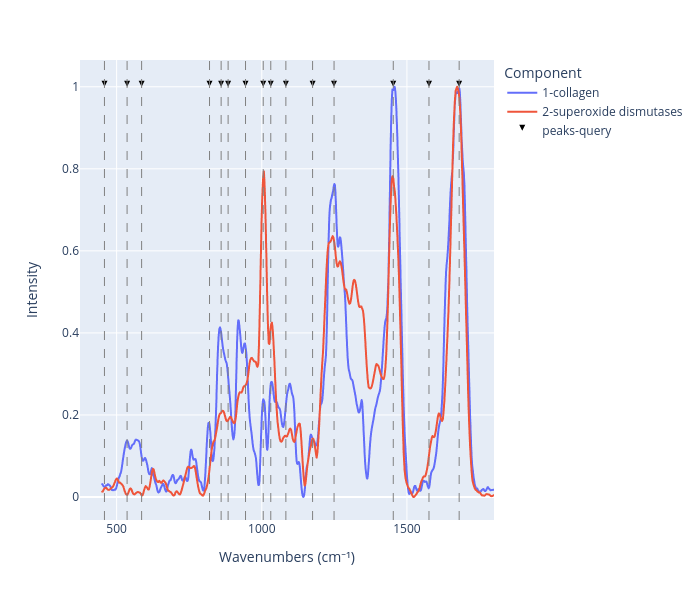

In [17]:
pm_search_results.plot_results(n=2)

If is available, it is possible to add the trace of the unknown_specturm. The trace should have intensity values for the wavenumbers defined when creating PeakMatchingSearch object.

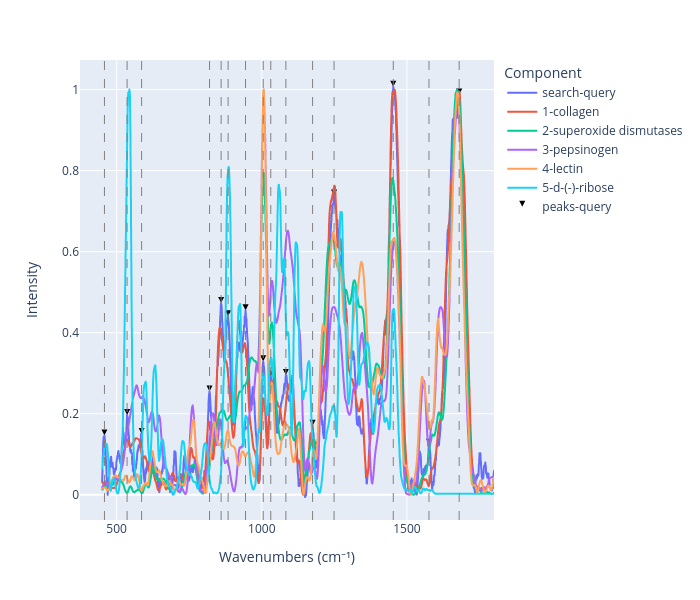

In [18]:
pm_search_results.plot_results(n=5, query_spectrum=unknown_spectrum)

Use plot_score to display the score decrement over the ranked results

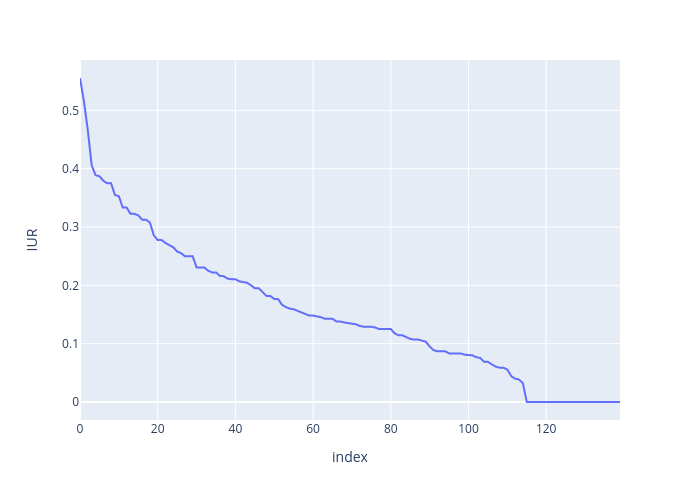

In [19]:
pm_search_results.plot_scores(metric='IUR')

Use plot_pm_scores_matrix to display the peak matching scores for each unkown spectrum extracted peak position for the top N results.  
The matching scores are between 0 and 1 based on the matching distance and the penalization function defined in the search.

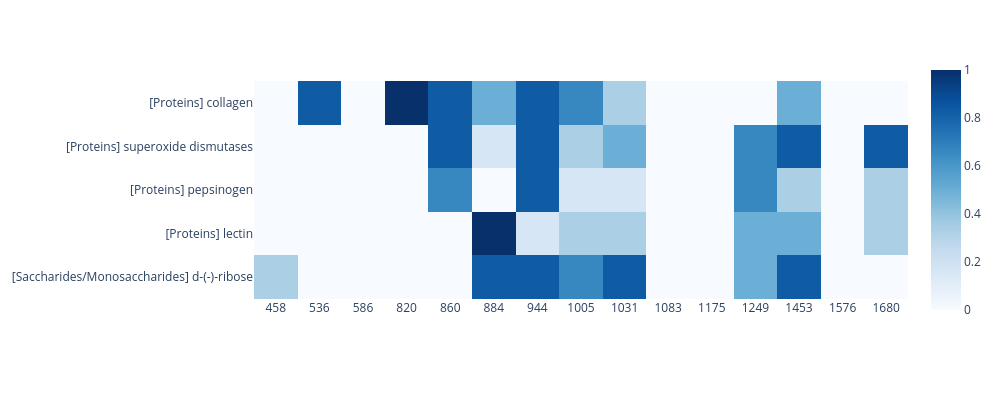

In [20]:
pm_search_results.plot_pm_scores_matrix(limit=5)

Use get_assignments to display the detail of the peak matched assignments for each extracted peak for a database component.  
If default is set the top result component is displayed.

In [21]:
pm_search_results.get_assignments(component='default')

,id,component,laser,reference,source,peak_query,peak_db,distance,type
0,106.0,collagen,532.0,https://doi.org/10.1002/jrs.4335,digitized,536.0,537.0,1.0,Proteins
1,106.0,collagen,532.0,https://doi.org/10.1002/jrs.4335,digitized,820.0,820.0,0.0,Proteins
2,106.0,collagen,532.0,https://doi.org/10.1002/jrs.4335,digitized,860.0,859.0,1.0,Proteins
3,106.0,collagen,532.0,https://doi.org/10.1002/jrs.4335,digitized,884.0,881.0,3.0,Proteins
4,106.0,collagen,532.0,https://doi.org/10.1002/jrs.4335,digitized,944.0,943.0,1.0,Proteins
5,106.0,collagen,532.0,https://doi.org/10.1002/jrs.4335,digitized,1005.0,1007.0,2.0,Proteins
6,106.0,collagen,532.0,https://doi.org/10.1002/jrs.4335,digitized,1031.0,1035.0,4.0,Proteins
7,106.0,collagen,532.0,https://doi.org/10.1002/jrs.4335,digitized,1453.0,1456.0,3.0,Proteins


Also any other database component can be displayed

In [22]:
pm_search_results.get_assignments(component='pepsinogen')

,id,component,laser,reference,source,peak_query,peak_db,distance,type
0,134.0,pepsinogen,488.0,https://doi.org/10.1002/jrs.4335,digitized,860.0,858.0,2.0,Proteins
1,134.0,pepsinogen,488.0,https://doi.org/10.1002/jrs.4335,digitized,944.0,945.0,1.0,Proteins
2,134.0,pepsinogen,488.0,https://doi.org/10.1002/jrs.4335,digitized,1005.0,1010.0,5.0,Proteins
3,134.0,pepsinogen,488.0,https://doi.org/10.1002/jrs.4335,digitized,1031.0,1036.0,5.0,Proteins
4,134.0,pepsinogen,488.0,https://doi.org/10.1002/jrs.4335,digitized,1249.0,1247.0,2.0,Proteins
5,134.0,pepsinogen,488.0,https://doi.org/10.1002/jrs.4335,digitized,1453.0,1457.0,4.0,Proteins
6,134.0,pepsinogen,488.0,https://doi.org/10.1002/jrs.4335,digitized,1680.0,1676.0,4.0,Proteins
